In [1]:
import pandas as pd
import numpy as np
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?'
url = url + 'accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B'
#url = 'https://www.ins.gov.co/BoletinesCasosCOVID19Colombia/'
#file = '2020-05-30.xlsx',
#data = pd.read_excel(url + file)
data = pd.read_csv(url, sep=';')

#Replace \n (newline) for all columns
data.rename(columns=lambda s: s.replace(' ', '_'), inplace=True)

#Información de latitud y longitud para los departamentos del dataset(únicamente)
data_geo = pd.read_csv('dataset/departamentos_geocode_lat_lon.csv')

#Feature Engineering
#Fechas
data['FIS'] = pd.to_datetime(data['FIS'], format='%Y-%m-%d', errors='coerce', yearfirst=True, exact=False)

data['Fecha_de_muerte'] = pd.to_datetime(data['Fecha_de_muerte'], format='%Y-%m-%d', errors='coerce',   
yearfirst=True, exact=False)

data['Fecha_diagnostico'] = pd.to_datetime(data['Fecha_diagnostico'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

data['Fecha_recuperado'] = pd.to_datetime(data['Fecha_recuperado'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

data['fecha_reporte_web'] = pd.to_datetime(data['fecha_reporte_web'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

#Estado
data['Estado'] = np.where(data['Estado'] == 'leve', 'Leve', data['Estado'])
data['Estado'] = data['Estado'].str.strip()
data['Departamento_o_Distrito_'] = data['Departamento_o_Distrito_'].str.strip()
data['Ciudad_de_ubicación'] = data['Ciudad_de_ubicación'].str.strip()
data['País_de_procedencia'] = data['País_de_procedencia'].str.strip()
data['Sexo'] = data['Sexo'].str.strip()
data['atención'] = data['atención'].str.strip()
data['Tipo'] = data['Tipo'].str.strip()
data['Sexo'] = data['Sexo'].str.upper()

#Feature Engenieering
#New Features
data['Recuperado'] = np.where(data['Fecha_recuperado'].notnull(), 'Si', 'No')
data['Falleció'] = np.where(data['Fecha_de_muerte'].notnull(), 'Si', 'No')
data['Extranjero'] = np.where(data['País_de_procedencia'] == 'Colombia', 'No', 'Si')

#Edad
data['Rango_Edad'] = pd.cut(x=data['Edad'], bins=[0, 5, 15, 25, 45, 65, 75, 999],
                    labels=['0-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75->'])

#Días Recuperación
data['FIS'].fillna(data['fecha_reporte_web'], inplace=True)
data['Días de tratamiento'] = abs(data['fecha_reporte_web'] - data['FIS'])
data['Días de tratamiento'] = data['Días de tratamiento'].astype('timedelta64[D]')
data['Días de tratamiento'].fillna(0, inplace=True)
data['Días de tratamiento'] = data['Días de tratamiento'].astype(int)

#Latitud y Longitud (para Departamento)
data = data.join(data_geo.set_index('Departamento'), on='Departamento_o_Distrito_')

#Display datafile info
print('Registros: {:,}'.format(data.shape[0]))

Registros: 88,591


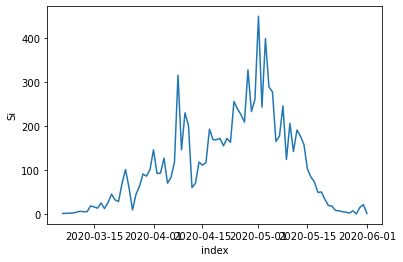

In [83]:
import seaborn as sns
sns.lineplot(x=df.index, y="Si", data=df)

In [3]:
data.columns

Index(['ID_de_caso', 'Fecha_de_notificación', 'Codigo_DIVIPOLA',
       'Ciudad_de_ubicación', 'Departamento_o_Distrito_', 'atención', 'Edad',
       'Sexo', 'Tipo', 'Estado', 'País_de_procedencia', 'FIS',
       'Fecha_de_muerte', 'Fecha_diagnostico', 'Fecha_recuperado',
       'fecha_reporte_web', 'Tipo_recuperación', 'Recuperado', 'Fallecio',
       'Extranjero', 'Ocupa_UCI', 'Rango_Edad', 'Dias_Recuperacion',
       'Dias_Sobrevivencia', 'Unnamed: 0', 'dpto_geocode', 'dpto_coords',
       'lat', 'lon'],
      dtype='object')

In [165]:
import plotly.express as px
dg = data.groupby(['fecha_reporte_web', 'Sexo'])['fecha_reporte_web'].agg(['count']).reset_index()
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig = px.line(dg, x=dg.fecha_reporte_web, y='Número de casos', labels={'x':'Fecha'}, color='Sexo')
fig.show()

In [154]:
import plotly.express as px
dg = data.groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig = px.line(dg, x=dg.index, y='Número de casos', labels={'x':'Fecha'})
fig.show()

In [176]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
#Total Casos
dg = data.groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines+markers',
                    name='Total Casos'))
#Total Casos : Mujeres
dg = data[data['Sexo'] == 'F'].groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines',
                    name='Mujeres'))

#Total Casos : Hombres
dg = data[data['Sexo'] == 'M'].groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines',
                    name='Hombres'))

fig.show()

In [15]:
#Missing Null Values
data['atención'].fillna(data['atención'].mode()[0], inplace=True)
data['Estado'].fillna(data['Estado'].mode()[0], inplace=True)
data['Tipo'].fillna(data['Tipo'].mode()[0], inplace=True)

In [2]:
data['atención'].value_counts()

Casa            19015
Recuperado      12921
Hospital         1695
Fallecido        1087
Hospital UCI      347
Name: atención, dtype: int64

In [26]:
data[data['Recuperado'] == 'Si']['Recuperado'].count()

11144

In [27]:
data[data['Días de tratamiento'] != 0]['Falleció'].value_counts()

No    11138
Si        6
Name: Falleció, dtype: int64

In [5]:
import plotly.express as px
fig = px.scatter(data[(data['Edad'] > 0)&(data['Días de tratamiento'] > 0)], x="Edad", y="Días de tratamiento", color='Falleció')
fig.show()

In [84]:
dg1 = data.groupby([pd.Grouper(key='fecha_reporte_web', freq='W')])['fecha_reporte_web'].count().to_frame()
dg1.rename(columns={'fecha_reporte_web':'Número de casos'}, inplace=True)
dg1

,Número de casos
fecha_reporte_web,
2020-03-08,1
2020-03-15,52
2020-03-22,188
2020-03-29,461
2020-04-05,783
2020-04-12,1291
2020-04-19,1017
2020-04-26,1542
2020-05-03,2329


In [94]:
#dg = data.groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
#dg.rename(columns={'count':'Número de casos'}, inplace=True)
dg = data.groupby([pd.Grouper(key='fecha_reporte_web', freq='W')])['fecha_reporte_web'].count().to_frame()
dg.rename(columns={'fecha_reporte_web':'Número de casos'}, inplace=True)
dg['Fila Anterior Número de casos'] = dg['Número de casos'].shift()
dg['Velocidad de Propagación'] = dg['Número de casos'] / dg['Fila Anterior Número de casos']
dg.drop(dg[dg.index < '2020-04-01'].index, inplace=True)

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=dg.index,
    y=dg['Velocidad de Propagación']
))
fig.add_shape(
        # Line Horizontal
            type="line",
            x0=dg.index.min(),
            y0=1,
            x1=dg.index.max(),
            y1=1,
            line=dict(
                color="green",
                width=2,
                dash="solid",
            ),
    )
fig.update_xaxes(title="Fecha")
fig.update_yaxes(title="Velocidad de Propagación (Semana a Semana)")


In [65]:
fc = dg[dg.index==dg.index.max()]['Factor de Crecimiento'][0]
print(fc)
#dg.index.max()['Factor de Creacimiento']

1.079625292740047


In [15]:
dg['Número de casos'].shift()

0         NaN
1         1.0
2         2.0
3         6.0
4         5.0
        ...  
106    2531.0
107    2389.0
108    3541.0
109    3486.0
110    3843.0
Name: Número de casos, Length: 111, dtype: float64

In [3]:
df = pd.crosstab(data['fecha_reporte_web'],data['Recuperado'], margins=True, margins_name='Total', rownames=['Fecha'], colnames=['Recuperado'])
df['Recuperados Acumulado'] = df['Si'].cumsum()
df['Total Recuperados Acumulado'] = df['Total'].cumsum()
df['% Acumulado Recuperados'] = (df['Recuperados Acumulado'] / df['Total Recuperados Acumulado'])*100
df

Recuperado,No,Si,Total,Recuperados Acumulado,Total Recuperados Acumulado,% Acumulado Recuperados
Fecha,,,,,,
2020-03-06 00:00:00,0,1,1,1,1,100.000000
2020-03-09 00:00:00,0,2,2,3,3,100.000000
2020-03-11 00:00:00,0,6,6,9,9,100.000000
2020-03-12 00:00:00,0,5,5,14,14,100.000000
2020-03-13 00:00:00,0,5,5,19,19,100.000000
...,...,...,...,...,...,...
2020-06-24 00:00:00,3484,57,3541,36165,77113,46.898707
2020-06-25 00:00:00,3422,64,3486,36229,80599,44.949689
2020-06-26 00:00:00,3799,44,3843,36273,84442,42.956112


In [16]:
import plotly.express as px
#dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig = px.line(df, x=df.index, y='% Acumulado Recuperados', labels={'x':'Fecha'})
fig.show()

In [2]:
df = pd.crosstab(data['Departamento_o_Distrito_'],data['Recuperado'], margins=True, margins_name='Total', rownames=['Departamento'], colnames=['Recuperado'])
df['% Recuperados'] = (df['Si'] / df['Total']) * 100
df

Recuperado,No,Si,Total,% Recuperados
Departamento,,,,
Amazonas,1383,469,1852,25.323974
Antioquia,695,505,1200,42.083333
Arauca,0,1,1,100.000000
Archipiélago de San Andrés Providencia y Santa Catalina,2,15,17,88.235294
Atlántico,1641,605,2246,26.936776
Barranquilla D.E.,1816,488,2304,21.180556
Bogotá D.C.,6628,4115,10743,38.304012
Bolívar,175,53,228,23.245614
Boyacá,111,101,212,47.641509


In [10]:
sorted(df[df['Total']<10].index)

['Arauca', 'Guainía', 'Putumayo', 'Vichada']

In [21]:
(df[df['Total']>0]['Total'].count()/df.shape[0])*100

100.0

In [20]:
df[df['Total']>0]['Total'].count()

33

In [3]:
df = pd.crosstab(data['atención'],data['Recuperado'], margins=True, margins_name='Total', rownames=['Fecha'], colnames=['Recuperado'])
df['Recuperados Acumulado'] = df['Si'].cumsum()
df['Total Recuperados Acumulado'] = df['Total'].cumsum()
df['% Acumulado Recuperados'] = (df['Recuperados Acumulado'] / df['Total Recuperados Acumulado'])*100
df

Recuperado,No,Si,Total,Recuperados Acumulado,Total Recuperados Acumulado,% Acumulado Recuperados
Fecha,,,,,,
Casa,18041,0,18041,0,18041,0.000000
Fallecido,1043,2,1045,2,19086,0.010479
Hospital,1591,0,1591,2,20677,0.009673
Hospital UCI,335,0,335,2,21012,0.009518
Recuperado,0,12288,12288,12290,33300,36.906907
Total,21010,12290,33300,24580,66600,36.906907


In [22]:
dg['Número de casos'].sum()

335

In [16]:
import plotly.express as px
dg = data.groupby(['fecha_reporte_web', 'atención'])['fecha_reporte_web'].agg(['count']).reset_index()
dg.rename(columns={'count':'Número de casos'}, inplace=True)
dg = dg[dg['atención'].isin(['Hospital UCI'])]
fig = px.line(dg, x=dg.fecha_reporte_web, y='Número de casos', labels={'x':'Fecha'}, color='atención')
fig.show()

In [66]:
import plotly.express as px
df = px.data.gapminder()

fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp",
	         size="pop", color="continent",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42078 entries, 0 to 42077
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID_de_caso                42078 non-null  int64         
 1   Fecha_de_notificación     42078 non-null  object        
 2   Codigo_DIVIPOLA           42078 non-null  int64         
 3   Ciudad_de_ubicación       42078 non-null  object        
 4   Departamento_o_Distrito_  42078 non-null  object        
 5   atención                  42011 non-null  object        
 6   Edad                      42078 non-null  int64         
 7   Sexo                      42078 non-null  object        
 8   Tipo                      42078 non-null  object        
 9   Estado                    42013 non-null  object        
 10  País_de_procedencia       42078 non-null  object        
 11  FIS                       42078 non-null  datetime64[ns]
 12  Fecha_de_muerte   

In [3]:
data[['lat','lon']]

,lat,lon
0,4.598080,-74.076044
1,4.063957,-76.123377
2,7.153843,-75.444040
3,7.153843,-75.444040
4,7.153843,-75.444040
...,...,...
42073,6.264634,-75.569321
42074,10.750008,-75.000009
42075,4.343593,-75.723290
42076,4.063957,-76.123377


In [5]:
data['lat'].isnull().sum()

2